In [1]:
!pip install padelpy
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files

from statistics import mean
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from padelpy import from_smiles
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors





# 1. Feature extraction

## Introduction

High-performance ML models rely on quality features to optimize their predictive power. Determining which features provide the most bang-for-your-buck is an integral part of designing a computationally efficient way of training your model.

In cheminformatics, determining which features are relevant for toxicity prediction is less intuitive than for most classroom examples. To better perform this task, we consulted existing cheminformatics literature.

**Tradeoffs & strategy**

An important tradeoff must be made between **number of features** and **computational cost**; without access to a more performant computer, the runtime required to calculate a high number of features for 200,000+ molecules is not trivial.

In order to keep the runtime reasonable, we will do two things in this notebook.

  1. **SOTA approach**:
    Extract large amount of molecular descriptors from a small subset using PaDEL, similar to published papers (see References)

  2. **Realistic approach**:
    Perform more limited feature extraction on the larger dataset to train our models

# 2. Data

Datasets have been uploaded to [GitHub](https://github.com/eevenepo/hERG_toxicity_assesment).

In [3]:
# Load data from GitHub
train_data = pd.read_csv("https://raw.githubusercontent.com/eevenepo/hERG_toxicity_assesment/main/train_data.csv")
del train_data['Unnamed: 0']

# Check data
print(f'Database size: {len(train_data.index)} molecules')

train_data.head()

Database size: 214825 molecules


,Drug,Y
0,COc1cccc(CNC(=O)c2ccc(C3SCCS3)cc2)c1,0
1,COc1cccc(/C=N/NC(=O)CSc2cccc3cccnc23)c1,0
2,O=C(CSc1cccc2cccnc12)N/N=C/c1ccc(F)cc1,0
3,CCOc1cc(/C=N/NC(=O)CSc2cccc3cccnc23)ccc1O,0
4,O=C(CSc1cccc2cccnc12)N/N=C/c1cccc(O)c1,0


# 3. Approach A: large featureset extraction (PaDEL)

[PaDEL-descriptor](https://onlinelibrary.wiley.com/doi/10.1002/jcc.21707)  is a program used to extract molecular descriptors from various chemical formats, including SMILES. It has been cited over 1,400 times in various cheminformatics papers, and is available in Python through [padelpy](https://github.com/ecrl/padelpy).

A major drawback is that due to the very extensive range of descriptors it provides (1875), the runtime can be quite long. We will illustrate this below.



In [4]:
def ConvertSectoDay(n):
  '''
  Convert seconds to d/h/m to illustrate PaDEL runtime
  '''
  day = n // (24 * 3600)
 
  n = n % (24 * 3600)
  hour = n // 3600
 
  n %= 3600
  minutes = n // 60
 
     
  return f'{day} days, {hour} hours, {minutes} minutes'


In [5]:
# Take a small subset 
example_drugs = list(train_data['Drug'][:5])

# Calculate PaDEL descriptors
times = []
total_time = 0
print('PaDEL runtime (seconds):')
for i, drug in enumerate(example_drugs):
  # start
  start = time.time()
  # Calculate features
  features = from_smiles(drug)
  # stop
  stop = time.time()
  # Time
  t = stop - start
  times.append(t)
  total_time += t

  # Output
  print(f'{i+1} molecules: {total_time}')

# Estimate runtime for complete dataset
avg_time = mean(times)
total_minutes = avg_time * len(train_data)

# Result
print(f'\nEstimated total runtime: {ConvertSectoDay(total_minutes)}')

PaDEL runtime (seconds):
1 molecules: 17.047362804412842
2 molecules: 35.09003257751465
3 molecules: 47.119969844818115
4 molecules: 59.15114641189575
5 molecules: 71.18073439598083

Estimated total runtime: 35.0 days, 9.0 hours, 31.0 minutes


Clearly, this is not a feasible approach. 

We mention it anyway, as the extremely large featureset is likely beneficial, given sufficient computational resources.

# 4. Approach B: Individual feature extraction (RDKit)

Featuresets used in cheminformatics research are often extremely large. PaDEL generates 1875 descriptors, other papers (s.a. [Computational determination of hERGrelated cardiotoxicity of drug candidates](https://doi.org/10.1186/s12859-019-2814-5)) clock in at 3,000+ features. Given that computational power is a strong limiting factor in this assignment, similar extensive featuresets are infeasible.

Models with less features may still perform at an acceptable level, given that the selected features exhibit sufficient correlation with the predicted variable (hERG toxicity).

We generated a number of features from [RDKit](https://www.rdkit.org/docs/index.html), an open source cheminformatics library, and ranked them by correlation to hERG toxicity.

**Feature requirements**
1. Function must take SMILES molecule as single input.
2. Output must be numeric.


In [6]:
#Load SMILES molecules into RDKit objects and add them to the dataframe
train_data['Drug_rdkit'] = [Chem.MolFromSmiles(drug) for drug in train_data['Drug']]

# List all candidate descriptor functions
function_list = [method for method in dir(rdMolDescriptors) if 'Calc' in method]

SMILES_example = train_data['Drug_rdkit'][0]

# Store valid functions
descriptors = []

# Test all functions
for f in function_list:
  # Check if SMILES as single input is valid
  try:
    descriptor = getattr(rdkit.Chem.rdMolDescriptors, f)
    result = descriptor(SMILES_example)
    # Check if output is numeric
    if isinstance(result, (int, float)):
      descriptors.append(descriptor.__name__)
  
  # Catch invalid functions
  except:
    pass

print(descriptors)


['CalcChi0n', 'CalcChi0v', 'CalcChi1n', 'CalcChi1v', 'CalcChi2n', 'CalcChi2v', 'CalcChi3n', 'CalcChi3v', 'CalcChi4n', 'CalcChi4v', 'CalcExactMolWt', 'CalcFractionCSP3', 'CalcHallKierAlpha', 'CalcKappa1', 'CalcKappa2', 'CalcKappa3', 'CalcLabuteASA', 'CalcNumAliphaticCarbocycles', 'CalcNumAliphaticHeterocycles', 'CalcNumAliphaticRings', 'CalcNumAmideBonds', 'CalcNumAromaticCarbocycles', 'CalcNumAromaticHeterocycles', 'CalcNumAromaticRings', 'CalcNumAtomStereoCenters', 'CalcNumAtoms', 'CalcNumBridgeheadAtoms', 'CalcNumHBA', 'CalcNumHBD', 'CalcNumHeavyAtoms', 'CalcNumHeteroatoms', 'CalcNumHeterocycles', 'CalcNumLipinskiHBA', 'CalcNumLipinskiHBD', 'CalcNumRings', 'CalcNumRotatableBonds', 'CalcNumSaturatedCarbocycles', 'CalcNumSaturatedHeterocycles', 'CalcNumSaturatedRings', 'CalcNumSpiroAtoms', 'CalcNumUnspecifiedAtomStereoCenters', 'CalcPhi', 'CalcTPSA', '_CalcMolWt']


We will apply these functions to the data.

In [8]:
features = pd.DataFrame()

for d in descriptors:
  descriptor = getattr(rdkit.Chem.rdMolDescriptors, d)
  result = descriptor(SMILES_example)
  features[d] = [descriptor(x) for x in train_data['Drug_rdkit']]
  print(f'Added {d}')

Added CalcChi0n
Added CalcChi0v
Added CalcChi1n
Added CalcChi1v
Added CalcChi2n
Added CalcChi2v
Added CalcChi3n
Added CalcChi3v
Added CalcChi4n
Added CalcChi4v
Added CalcExactMolWt
Added CalcFractionCSP3
Added CalcHallKierAlpha
Added CalcKappa1
Added CalcKappa2
Added CalcKappa3
Added CalcLabuteASA
Added CalcNumAliphaticCarbocycles
Added CalcNumAliphaticHeterocycles
Added CalcNumAliphaticRings
Added CalcNumAmideBonds
Added CalcNumAromaticCarbocycles
Added CalcNumAromaticHeterocycles
Added CalcNumAromaticRings
Added CalcNumAtomStereoCenters
Added CalcNumAtoms
Added CalcNumBridgeheadAtoms
Added CalcNumHBA
Added CalcNumHBD
Added CalcNumHeavyAtoms
Added CalcNumHeteroatoms
Added CalcNumHeterocycles
Added CalcNumLipinskiHBA
Added CalcNumLipinskiHBD
Added CalcNumRings
Added CalcNumRotatableBonds
Added CalcNumSaturatedCarbocycles
Added CalcNumSaturatedHeterocycles
Added CalcNumSaturatedRings
Added CalcNumSpiroAtoms
Added CalcNumUnspecifiedAtomStereoCenters
Added CalcPhi
Added CalcTPSA
Added _Ca

# 5. Correlation

Take a look at the data.

In [9]:
features.head()

,CalcChi0n,CalcChi0v,CalcChi1n,CalcChi1v,CalcChi2n,CalcChi2v,CalcChi3n,CalcChi3v,CalcChi4n,CalcChi4v,...,CalcNumRings,CalcNumRotatableBonds,CalcNumSaturatedCarbocycles,CalcNumSaturatedHeterocycles,CalcNumSaturatedRings,CalcNumSpiroAtoms,CalcNumUnspecifiedAtomStereoCenters,CalcPhi,CalcTPSA,_CalcMolWt
0,12.950466,14.583459,7.503768,9.601277,5.229724,7.954092,3.654042,6.758439,2.409318,5.268691,...,3,5,0,1,1,0,0,5.514806,38.33,345.489
1,13.677132,14.493628,7.685862,8.671460,5.189738,6.206915,3.451129,4.498091,2.268894,3.102107,...,3,6,0,0,0,0,0,5.637742,63.58,351.431
2,12.646848,13.463345,7.262472,8.248070,4.964675,5.981852,3.227340,4.274302,2.095918,2.929131,...,3,5,0,0,0,0,0,5.176454,54.35,339.395
3,14.754102,15.570598,8.413669,9.399267,5.573299,6.590475,3.641040,4.688002,2.429204,3.262417,...,3,7,0,0,0,0,0,6.272319,83.81,381.457
4,12.716097,13.532594,7.297096,8.282695,5.008110,6.025287,3.227545,4.274507,2.152171,2.985383,...,3,5,0,0,0,0,0,5.076824,74.58,337.404


## 5.1 Correlation to Y

To get an idea of predictive power, we can calculate the correlation between the toxicity and descriptors.

In [10]:
def correlations(outcome, features):
  '''
  Returns correlation between dependent variable and all given predictors
  '''
  correlations = []
  for i in features:
    corr = outcome.corr(features[i])
    correlations.append((i, abs(corr)))

  # Return in descending order 
  return sorted(correlations, key=lambda t: t[1], reverse=True)

correlations(train_data['Y'], features)

[('CalcChi1n', 0.15134178455728842),
 ('CalcNumAtoms', 0.1504109979239712),
 ('CalcChi3n', 0.14849275491555902),
 ('CalcChi2n', 0.14272514079351142),
 ('CalcKappa2', 0.13886213665433408),
 ('CalcChi4n', 0.13859643032736782),
 ('CalcChi0n', 0.1351297287962824),
 ('CalcLabuteASA', 0.13321076408846919),
 ('CalcChi0v', 0.1331298971284128),
 ('CalcChi1v', 0.12733875248526333),
 ('CalcPhi', 0.12581630045365585),
 ('CalcNumHeavyAtoms', 0.12341544943306083),
 ('CalcKappa1', 0.12331623846013513),
 ('_CalcMolWt', 0.1194694053414909),
 ('CalcExactMolWt', 0.11939890449442583),
 ('CalcNumRings', 0.11185011563882624),
 ('CalcKappa3', 0.10932876025479875),
 ('CalcChi2v', 0.10546253666296612),
 ('CalcChi3v', 0.1048538281917672),
 ('CalcNumSaturatedHeterocycles', 0.10418560855526492),
 ('CalcChi4v', 0.09588056236689503),
 ('CalcNumRotatableBonds', 0.09002149627333657),
 ('CalcNumAliphaticHeterocycles', 0.08776345463169709),
 ('CalcNumHeterocycles', 0.08532934197982747),
 ('CalcNumSaturatedRings', 0.075

We notice rather weak correlations between the top features and the toxicity. Though this is suboptimal, it is not wholly unexpected. In [Computational determination of hERGrelated cardiotoxicity of drug candidates](https://doi.org/10.1186/s12859-019-2814-5); out of 3456(!) features, the top 20 most correlated features never exceeded correlation coefficients of 0.23.

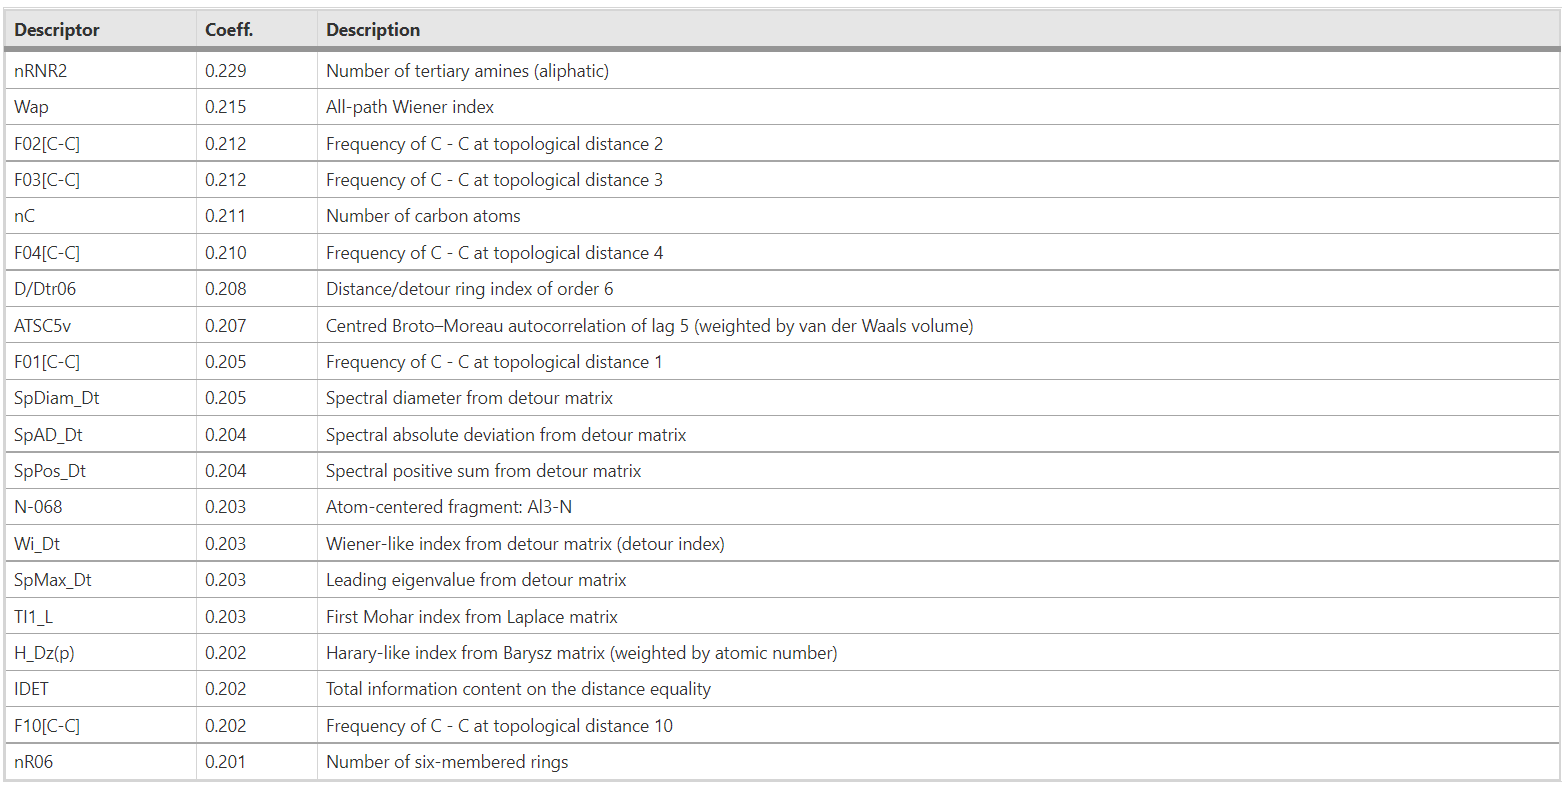

Though correlation between predictors and outcome is important, comparing correlation between predictors is useful to detect multicolinearity.

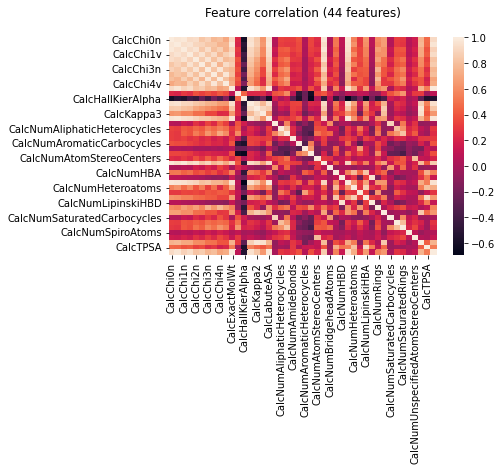

In [12]:
# Add the predictors to feature df
def show_corr_matrix(df):
  cor_matrix = df.corr()
  sn.heatmap(cor_matrix, annot=False)
  plt.title(f'Feature correlation ({len(df.columns)} features)\n')
  plt.show()


show_corr_matrix(features)

The heatmap shows extremely high correlation between several predictors. It can be explained by looking at the descriptors, which often perform quite similar searches (e.g. chemical ring structures can be several types, resulting in similar descriptor values for the same molecule.)

To try and mitigate this multicollinearity, we will progressively drop features exhibiting excessive variance inflation factors (VIF).

In [13]:
def calculate_VIFs(df):
  '''
  Calculates variance inflation factors for all features. Assumes constant is already added.
  '''
  return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).sort_values()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


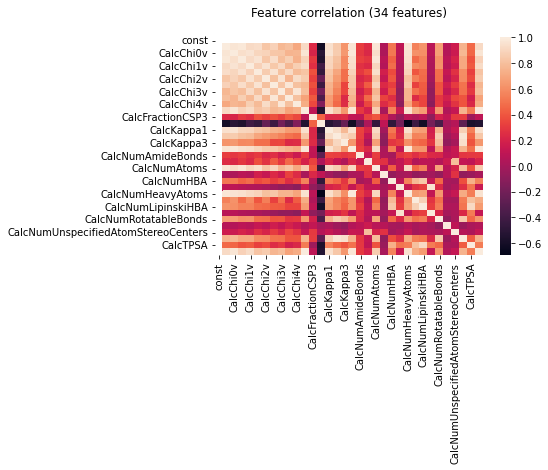

In [14]:
# Create copy of features with added constant for VIF calculation
X = add_constant(features)

# Get starting vif for all descriptors
vif_start = calculate_VIFs(X)

# Remove features with infinite VIF
for feature,vif in vif_start.items():
  if str(vif) == 'inf':
    # Drop from copy df
    del X[feature]

show_corr_matrix(X)

In [15]:
while len(X.columns) > 10:

  # Get VIFs of current dataframe
  vifs = calculate_VIFs(X)

  # Find feature with highest VIF
  worst_feat = vifs.index[-1]

  #vRemove it & recalculate
  del X[worst_feat]
  print(f'Removed {worst_feat}')


Removed CalcExactMolWt
Removed CalcNumHeavyAtoms
Removed CalcNumAtoms
Removed CalcChi0n
Removed CalcLabuteASA
Removed CalcChi1n
Removed CalcKappa2
Removed CalcChi3n
Removed CalcChi0v
Removed CalcChi2v
Removed CalcKappa1
Removed const
Removed CalcChi1v
Removed CalcChi3v
Removed _CalcMolWt
Removed CalcChi2n
Removed CalcNumLipinskiHBA
Removed CalcPhi
Removed CalcChi4n
Removed CalcNumHeteroatoms
Removed CalcTPSA
Removed CalcNumHBD
Removed CalcKappa3
Removed CalcHallKierAlpha


We will summarize the resulting data.

                            Descriptor        VIF  Y-correlation
0                    CalcNumSpiroAtoms   1.078271      -0.004632
1               CalcNumBridgeheadAtoms   1.182159      -0.009544
2                    CalcNumAmideBonds   2.398953      -0.035420
3                   CalcNumLipinskiHBD   2.748582      -0.060668
4  CalcNumUnspecifiedAtomStereoCenters   3.367410       0.002101
5             CalcNumAtomStereoCenters   3.507406      -0.003422
6                     CalcFractionCSP3   4.658069       0.059368
7                CalcNumRotatableBonds   8.354192       0.090021
8                           CalcNumHBA   9.920107       0.027237
9                            CalcChi4v  10.637982       0.095881


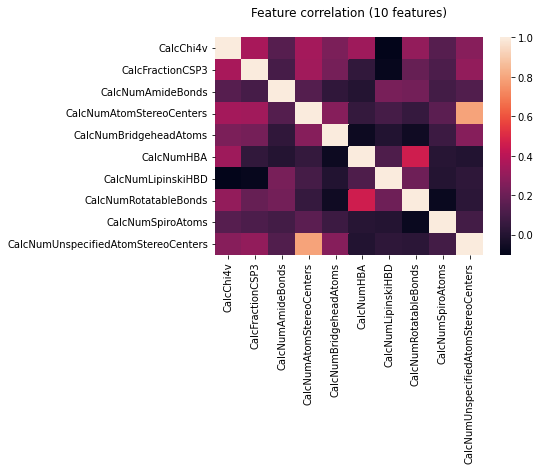

In [16]:
# Initialize summary df
summary_df = pd.DataFrame(columns = ['Descriptor', 'VIF', 'Y-correlation'])

# Add descriptors, VIFS and correlations with Y
vifs = calculate_VIFs(X)
for name, value in vifs.items():
  cor = train_data['Y'].corr(X[name])
  summary_df.loc[len(summary_df)] = [name, value, cor]

print(summary_df)
show_corr_matrix(X)

We've traded off extremely large multicollinearity for a smaller featureset with seemingly extremely low predictive power. Though not optimal, keep in mind that Pearson correlation is not a universal proxy for predictive power, as it only captures linear relationships. 

We save this data to use with our models.

In [18]:
# Add the outcome
X['Y'] = train_data['Y']

# Write preprocessed data to .csv
X.to_csv('preprocessed_data.csv', encoding = 'utf-8-sig') 
files.download('preprocessed_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>